# Data exploration

## Load annotations

In [1]:
import pandas as pd
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from IPython.display import Audio, display
from librosa.core import reassigned_spectrogram as librosa_tfr_spec
from tqdm import tqdm

In [2]:

annotations_csv = Path("~/data/kenya_birds/annotations.csv").expanduser()
recordings_path = Path("~/data/kenya_birds/soundscape_data/").expanduser()

print("annotations: ", annotations_csv.exists())
print("recordings: ", recordings_path.exists())

annotations:  True
recordings:  True


In [3]:
df = pd.read_csv(annotations_csv)

df.head(20)

,Filename,Start Time (s),End Time (s),Species eBird Code
0,KEN_001_20211207_153852.flac,67.8,67.8,slcbou1
1,KEN_001_20211207_153852.flac,106.8,106.8,slcbou1
2,KEN_001_20211207_153852.flac,107.5,107.5,hamerk1
3,KEN_001_20211207_153852.flac,118.4,118.4,slcbou1
4,KEN_001_20211207_153852.flac,209.1,209.1,hamerk1
5,KEN_001_20211207_153852.flac,211.5,211.5,hamerk1
6,KEN_001_20211207_153852.flac,213.6,213.6,hamerk1
7,KEN_001_20211207_153852.flac,248.3,248.3,hamerk1
8,KEN_001_20211207_153852.flac,287.3,287.3,hamerk1
9,KEN_001_20211207_153852.flac,288.4,288.4,hamerk1


In [4]:
print("Total annotations:", len(df))
print("Unique recordings:", df['Filename'].nunique())
print("Unique species:", df['Species eBird Code'].nunique())

Total annotations: 10294
Unique recordings: 35
Unique species: 176


In [5]:
missing = [recordings_path/f for f in df['Filename'].unique() if not (recordings_path/f).exists() ]
print("Missing files:", len(missing))
if missing:
    print(missing[:10])

Missing files: 0


## class imbalance analysis

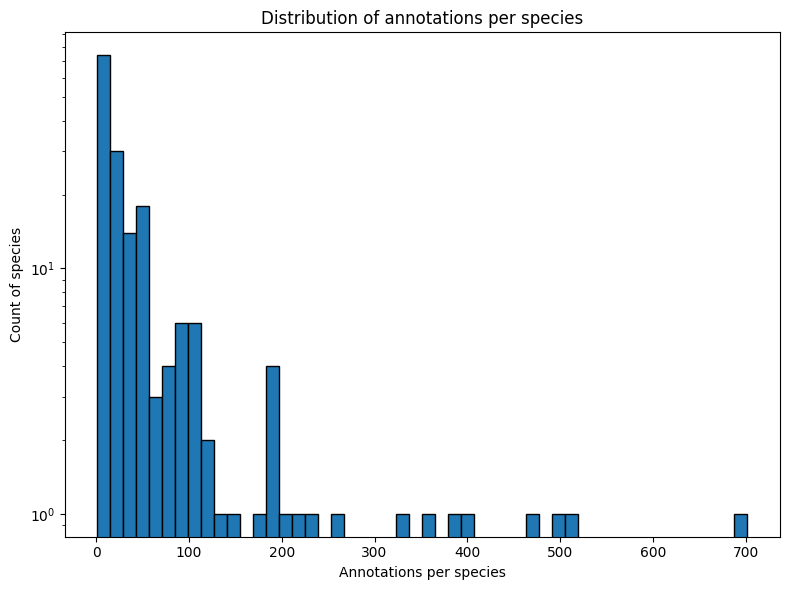

Species eBird Code
combul2    702
reccor     508
rbsrob1    494
wbswea1    469
gnbcam2    406
slcbou1    383
yebapa1    362
wbrcha2    325
egygoo     254
pygbat1    237
fotdro5    217
blnmou1    203
rindov     197
subbus1    192
marsun2    192
spemou2    191
sccsun2    175
wbgbir1    143
yewgre1    131
afgfly1    127
abethr1    123
trobou1    109
rufcha2    103
ratcis1    100
mcptit1    100
refcro1    100
gryapa1    100
abhori1     93
tafpri1     91
hadibi1     91
Name: count, dtype: int64


In [6]:
species_counts = df['Species eBird Code'].value_counts()

ax = species_counts.hist(
    bins=50,
    log=True, # log axis on y                
    figsize=(8,6),
    grid=False,
    edgecolor='black'
)
ax.set_title("Distribution of annotations per species")
ax.set_xlabel("Annotations per species")
ax.set_ylabel("Count of species")
plt.tight_layout()
plt.show()

print(species_counts.head(30))

## Call duration anomalies

count    10294.000000
mean         0.000068
std          0.002607
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.100000
Name: duration, dtype: float64


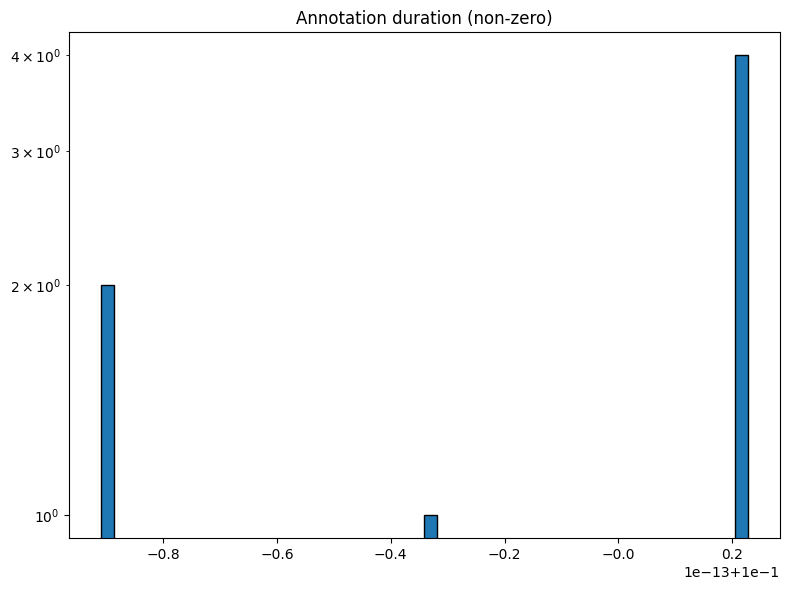

Point annotations: 10287


In [7]:
# If start==end, treat as point annotation: set a small duration like 0.1s or use window later
df['duration'] = df['End Time (s)'] - df['Start Time (s)']
# If zero-duration, mark as point
df['is_point'] = df['duration'] <= 0

print(df['duration'].describe())
plt.figure(figsize=(8,4))
# sns.histplot(df.loc[~df['is_point'], 'duration'], bins=100)
ax = df.loc[~df['is_point'], 'duration'].hist(
    bins=50,
    log=True, # log axis on y                
    figsize=(8,6),
    grid=False,
    edgecolor='black'
)
# ax.set_ xlim(0, 5)  # view typical call lengths
ax.set_title("Annotation duration (non-zero)")
plt.tight_layout()
plt.show()

# How many point annotations?
print("Point annotations:", df['is_point'].sum())

## Audio file analysis

In [8]:
files = df['Filename'].unique()
file_info = []
for f in files:
    path = recordings_path/f
    try:
        info = sf.info(path)
        file_info.append({'file': f, 'samplerate': info.samplerate, 'frames': info.frames, 'duration': info.frames / info.samplerate})
    except Exception as e:
        file_info.append({'file': f, 'samplerate': None, 'frames': None, 'duration': None, 'error': str(e)})
file_info = pd.DataFrame(file_info)
display(file_info.head())
print(file_info['samplerate'].value_counts())

,file,samplerate,frames,duration
0,KEN_001_20211207_153852.flac,32000,115200000,3600.000000
1,KEN_002_20211208_042640.flac,32000,113307404,3540.856375
2,KEN_003_20211209_072349.flac,32000,115200000,3600.000000
3,KEN_004_20211210_040250.flac,32000,115200000,3600.000000
4,KEN_005_20211210_050250.flac,32000,115200000,3600.000000


samplerate
32000    35
Name: count, dtype: int64


## Event plot

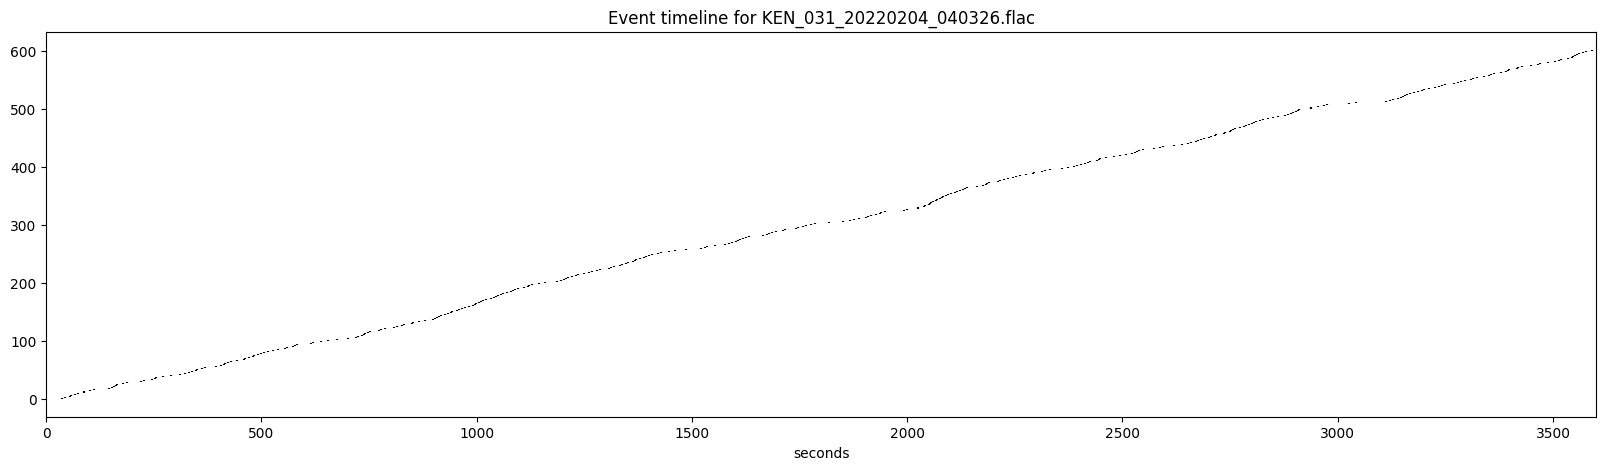

In [9]:
# Make a density plot across the hour for a file
example_file = df['Filename'].mode()[0]
fdf = df[df['Filename']==example_file]
plt.figure(figsize=(20,5))
plt.eventplot([ (r['Start Time (s)'], r['End Time (s)']) for _, r in fdf.iterrows() ], colors='black')
plt.title(f"Event timeline for {example_file}")
plt.xlim(0, file_info.loc[file_info.file==example_file, 'duration'].iloc[0])
plt.xlabel("seconds")
plt.show()

## Frequency ranges

100%|██████████| 10294/10294 [00:12<00:00, 835.73it/s]


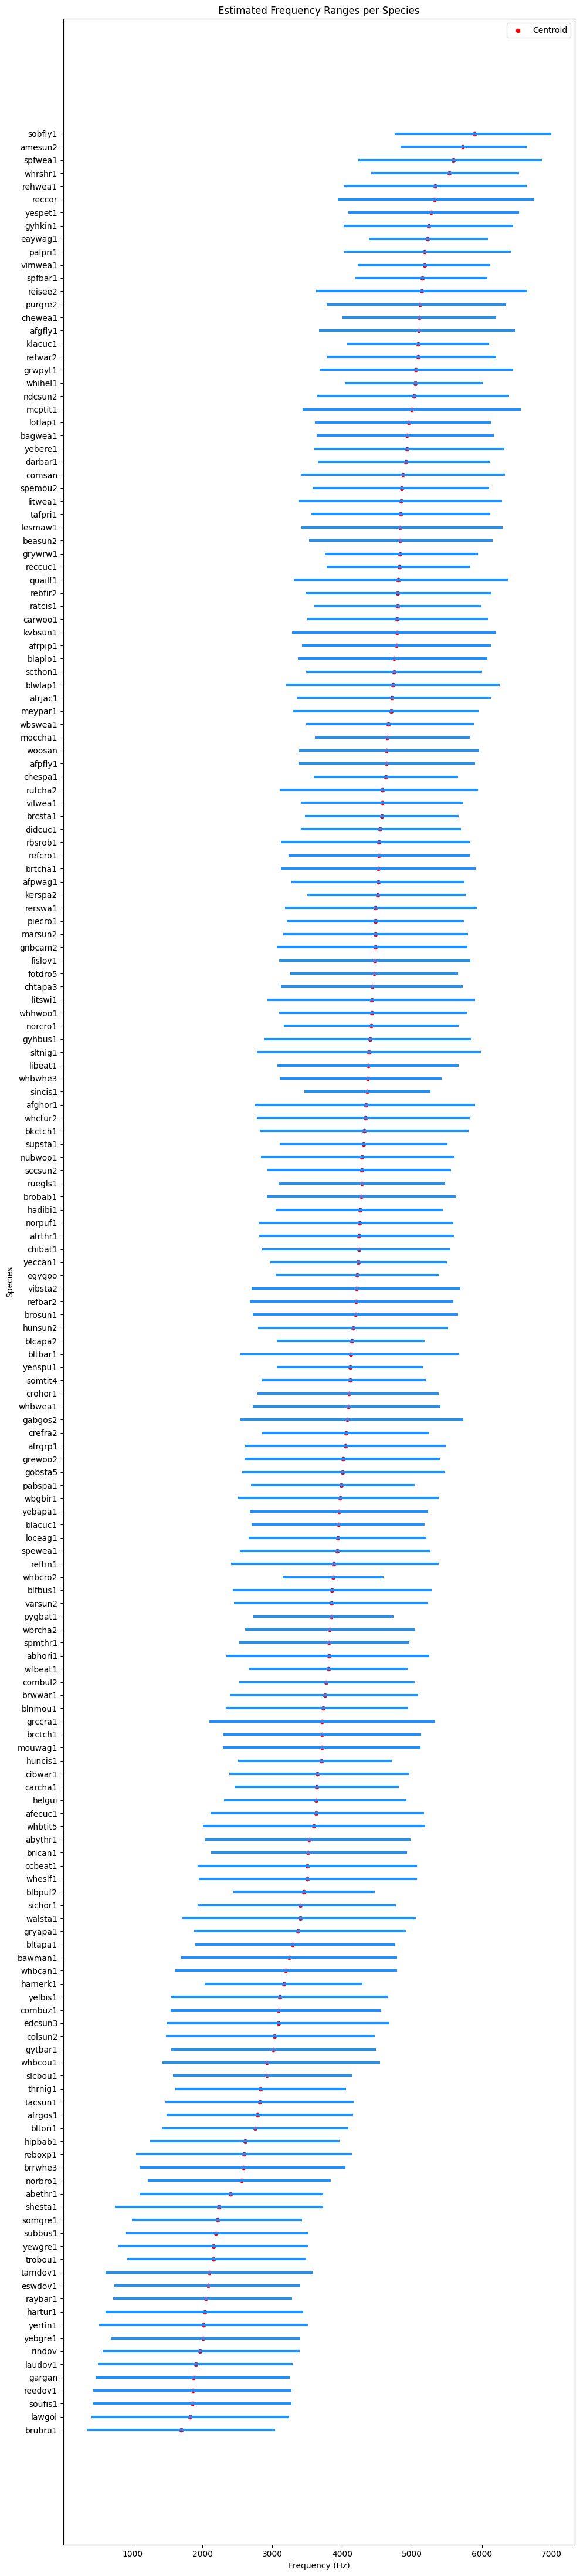

In [10]:
def compute_freq_range(path, start, end, sr_target=22050):
    """Compute low/high/centroid frequencies using librosa features."""
    duration = max(0.1, end - start)
    y, sr = librosa.load(path, sr=sr_target, offset=start, duration=duration)

    # Compute spectral features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # Take mean across frames
    centroid = float(np.mean(centroid))
    bandwidth = float(np.mean(bandwidth))

    # Compute frequency range
    low = max(0.0, centroid - bandwidth / 2)
    high = centroid + bandwidth / 2

    return low, high, centroid

results = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    path = recordings_path / row['Filename']
    low, high, centroid = compute_freq_range(
        path,
        start=row['Start Time (s)'],
        end=row['End Time (s)']
    )
    results.append({
        "Species": row['Species eBird Code'],
        "low_Hz": low,
        "high_Hz": high,
        "centroid_Hz": centroid
    })

freq_df = pd.DataFrame(results)
species_stats = (
    freq_df.groupby("Species")[["low_Hz", "high_Hz", "centroid_Hz"]]
    .agg(["min", "median", "max"])
)

species_stats.columns = ['_'.join(c) for c in species_stats.columns]
species_stats = species_stats.sort_values("centroid_Hz_median")

plt.figure(figsize=(10, len(species_stats) * 0.25))
plt.hlines(
    y=species_stats.index,
    xmin=species_stats["low_Hz_median"],
    xmax=species_stats["high_Hz_median"],
    color='dodgerblue', lw=3
)
plt.scatter(species_stats["centroid_Hz_median"], species_stats.index, color='red', s=20, label="Centroid")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Species")
plt.title("Estimated Frequency Ranges per Species")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
outliers = freq_df.query("centroid_Hz < low_Hz or centroid_Hz > high_Hz")
print(len(outliers), "outliers found")

0 outliers found


In [14]:
species_stats["range_width"] = (
    species_stats["high_Hz_median"] - species_stats["low_Hz_median"]
)

narrow_species = species_stats[species_stats["range_width"] < 500]  # very narrow
wide_species = species_stats[species_stats["range_width"] > 8000]  # very wide

print("Narrow-band species:")
display(narrow_species.head())

print("Wide-band species:")
display(wide_species.head())


Narrow-band species:


,low_Hz_min,low_Hz_median,low_Hz_max,high_Hz_min,high_Hz_median,high_Hz_max,centroid_Hz_min,centroid_Hz_median,centroid_Hz_max,range_width
Species,,,,,,,,,,


Wide-band species:


,low_Hz_min,low_Hz_median,low_Hz_max,high_Hz_min,high_Hz_median,high_Hz_max,centroid_Hz_min,centroid_Hz_median,centroid_Hz_max,range_width
Species,,,,,,,,,,


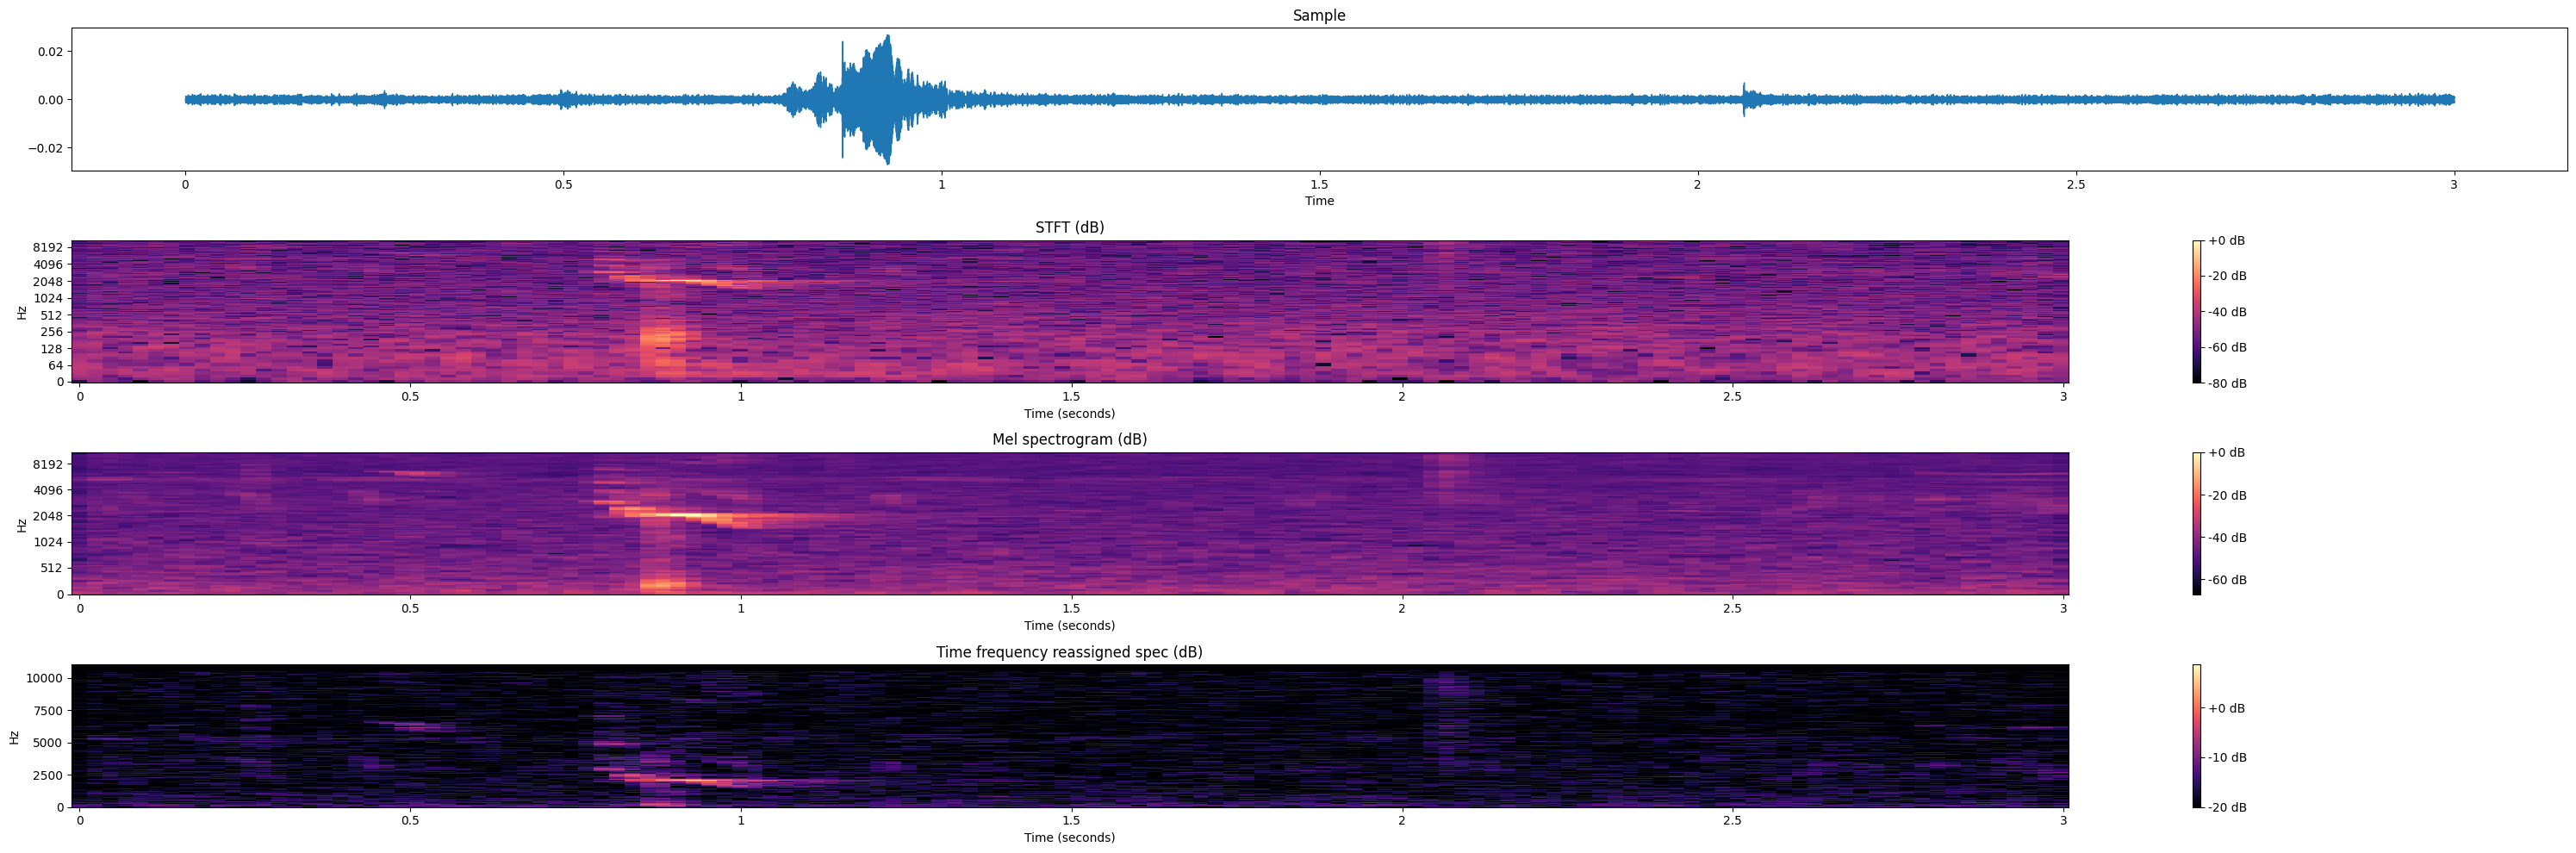

In [12]:
def show_specs(path, center_time, dur=3.0, sr_target=22050):
    y, sr = librosa.load(path, sr=sr_target, offset=max(0, center_time - dur/2), duration=dur)
    # STFT
    D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    # Mel
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # time frequency reassigned
    freqs, times, tfr_Sxx = librosa_tfr_spec(y=y, sr=sr, n_fft=2048, hop_length=512)
    tfr_Sxx_db = librosa.power_to_db(tfr_Sxx, amin=1e-2)

    
    
    plt.figure(figsize=(30,10))
    
    plt.subplot(4,1,1)
    librosa.display.waveshow(y)
    plt.title('Sample')

    plt.subplot(4,1,2)
    librosa.display.specshow(D_db, sr=sr, x_axis='s', y_axis='log')
    plt.title('STFT (dB)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(4,1,3)
    librosa.display.specshow(mel_db, sr=sr, x_axis='s', y_axis='mel')
    plt.title('Mel spectrogram (dB)')
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(4,1,4)
    librosa.display.specshow(tfr_Sxx_db, x_axis='s', y_axis="linear")
    plt.title('Time frequency reassigned spec (dB)')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Example
r = df.iloc[0]
example_file = recordings_path/df['Filename'].mode()[0]
center_time = (r['Start Time (s)'] + r['End Time (s)']) / 2
dur = 3.0  # seconds

# Load slice
y, sr = librosa.load(example_file, sr=None,
                     offset=max(0, center_time - dur/2),
                     duration=dur)

# Display spectrogram
show_specs(example_file, center_time, dur=dur)
display(Audio(y, rate=sr, autoplay=False))


## Cocktail party

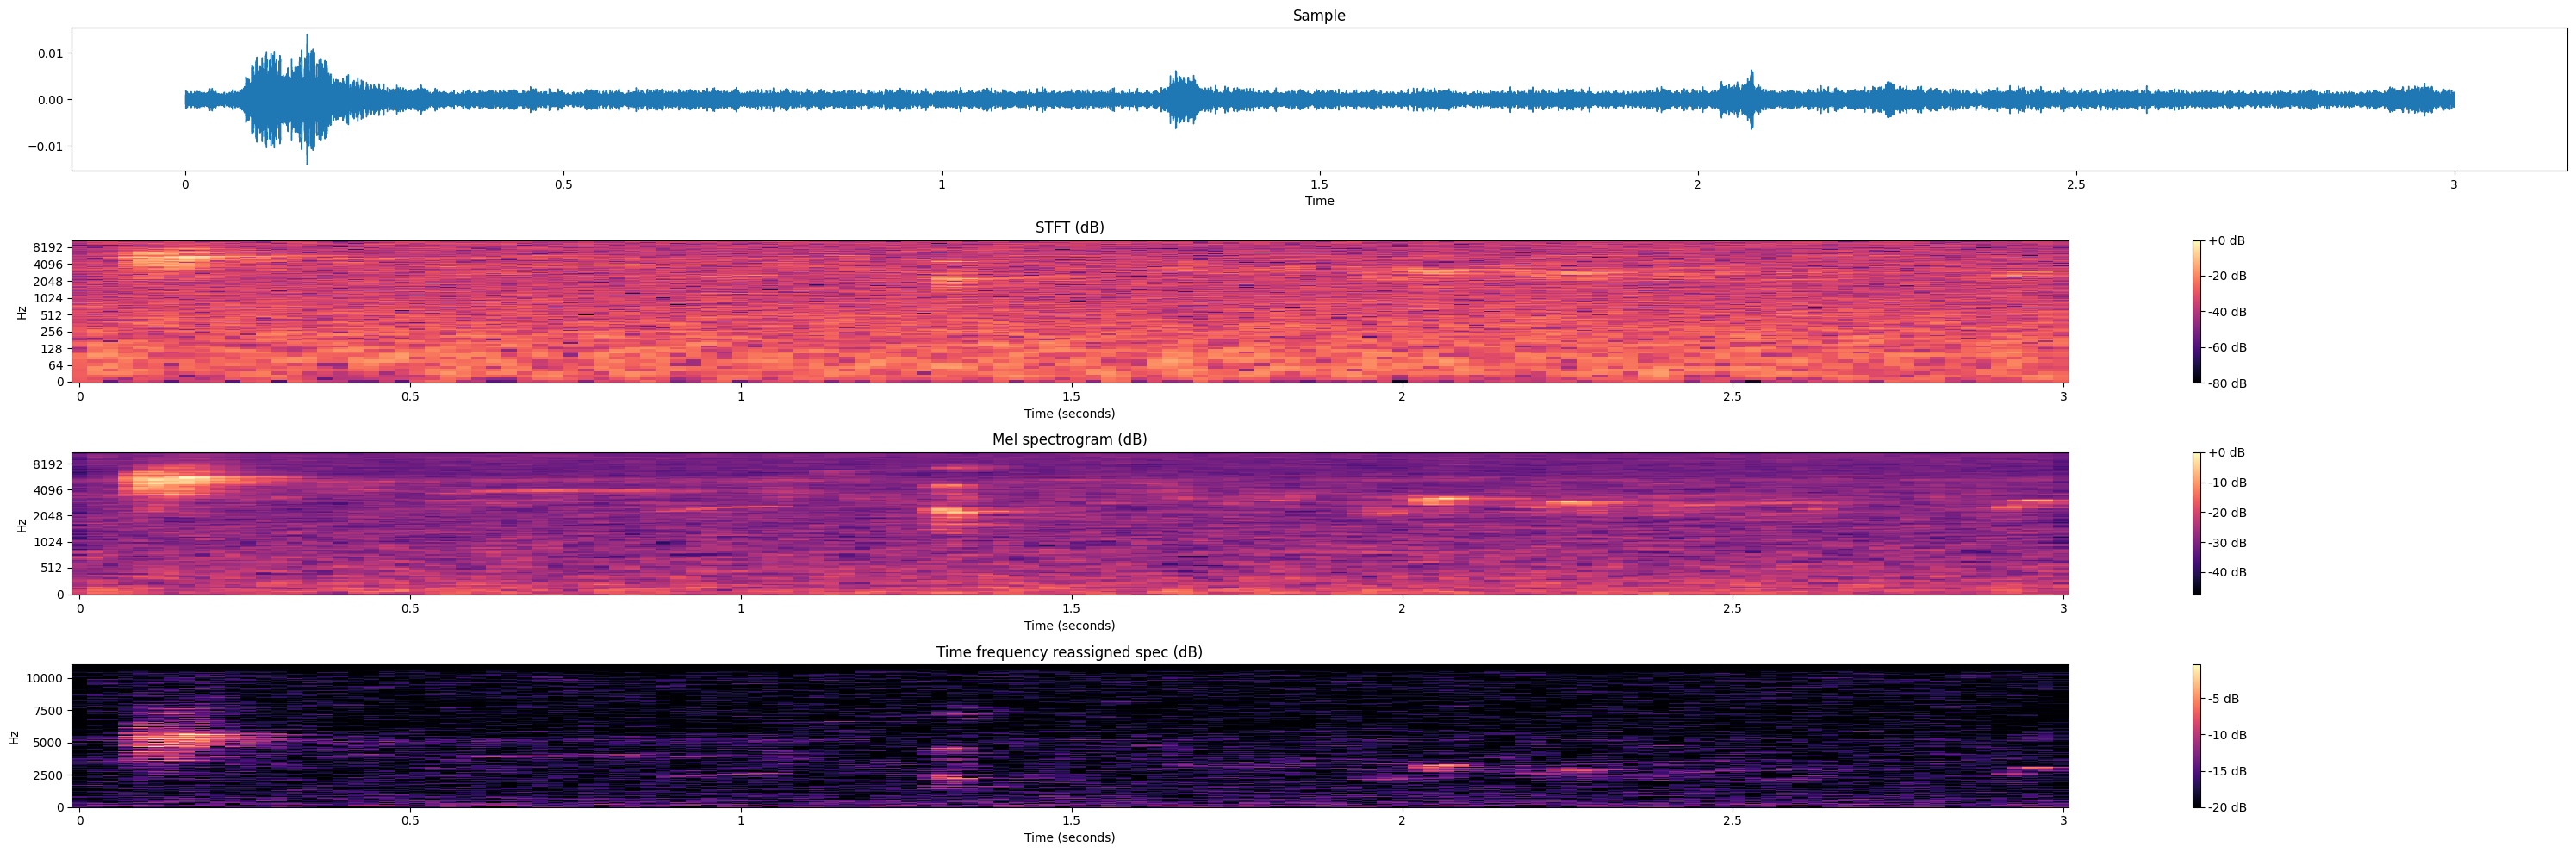

In [13]:
# Example
r = df.iloc[101]
example_file = recordings_path/df['Filename'].mode()[0]
center_time = (r['Start Time (s)'] + r['End Time (s)']) / 2
dur = 3.0  # seconds

# Load slice
y, sr = librosa.load(example_file, sr=None,
                     offset=max(0, center_time - dur/2),
                     duration=dur)

# Display spectrogram
show_specs(example_file, center_time, dur=dur)
display(Audio(y, rate=sr, autoplay=False))

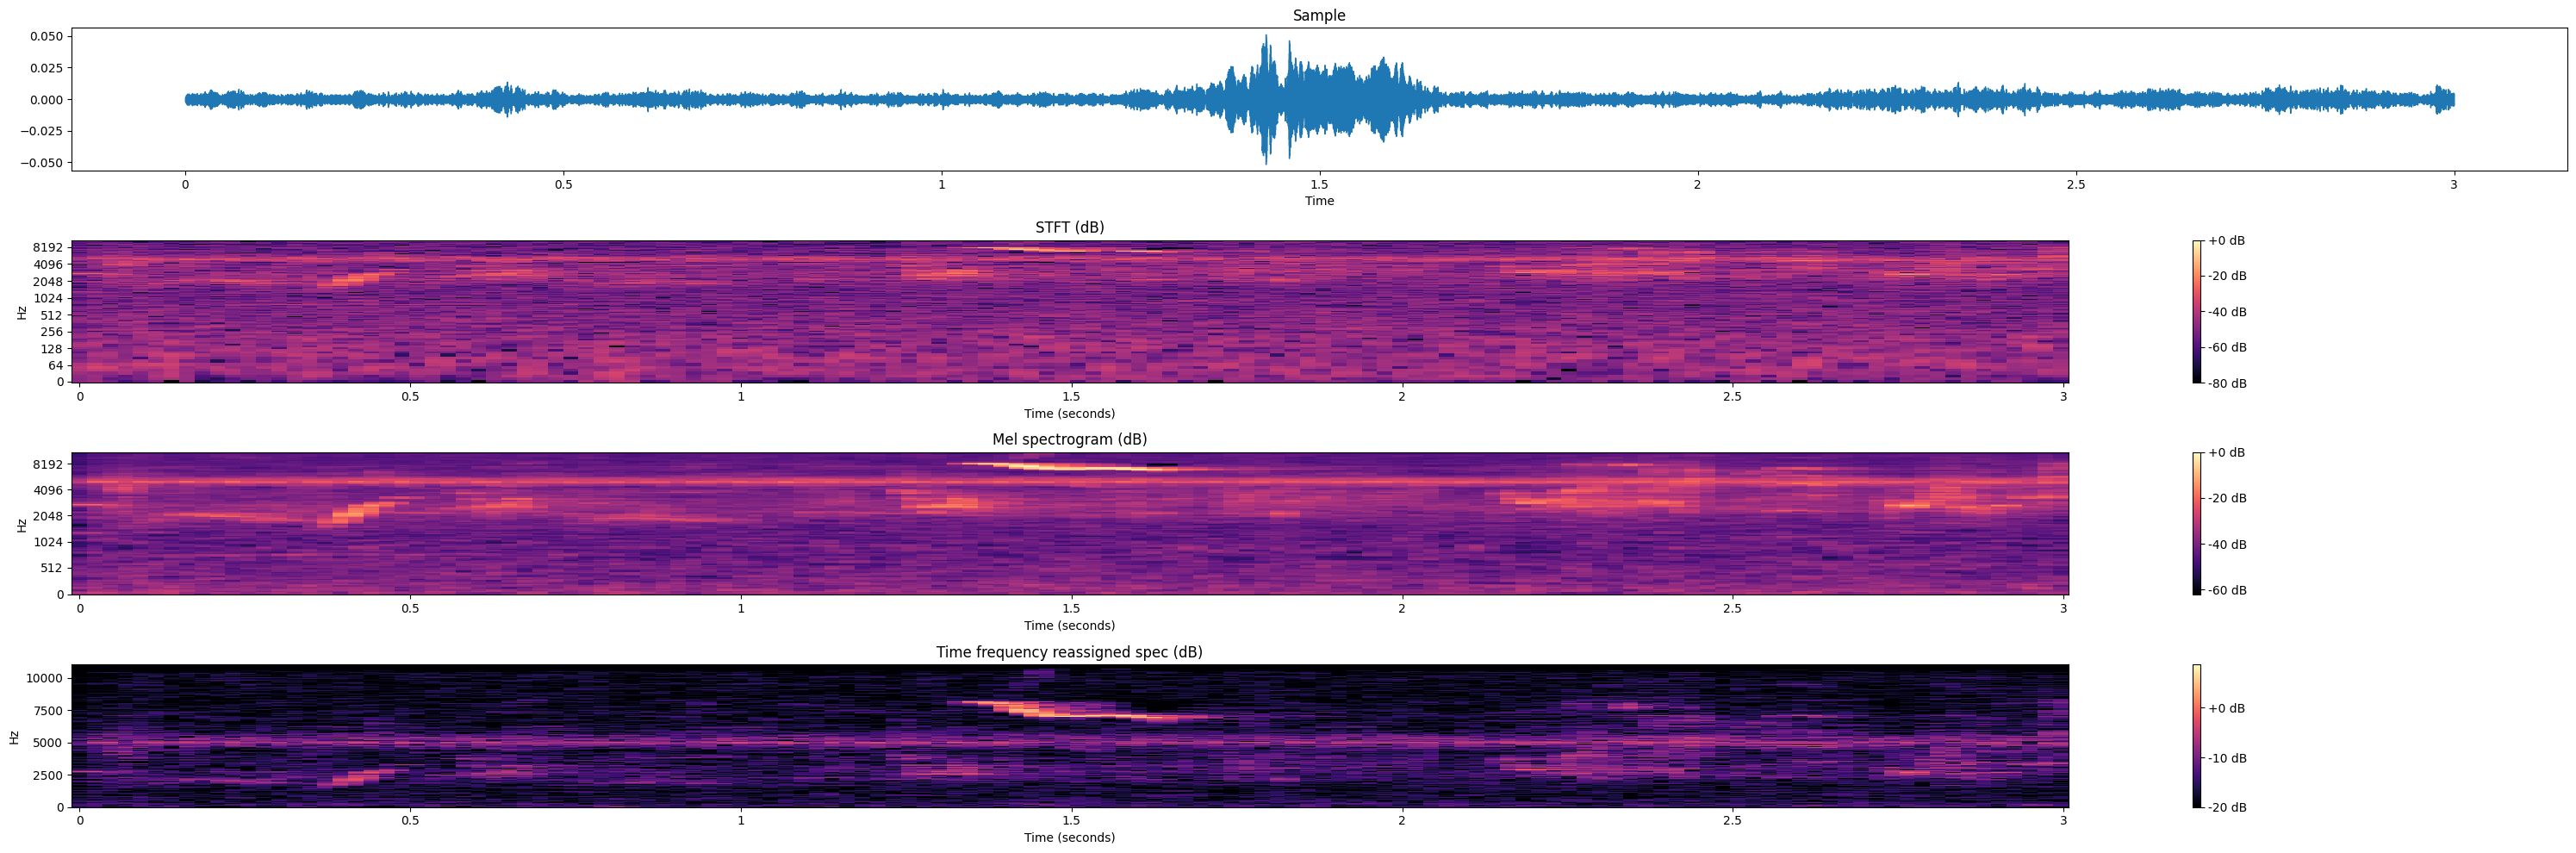

In [18]:
species = "sobfly1"
r = df[df["Species eBird Code"] == species].sample(1).iloc[0]  # random example

example_file = recordings_path / r["Filename"]
center_time = (r["Start Time (s)"] + r["End Time (s)"]) / 2
dur = 3.0

y, sr = librosa.load(example_file, sr=None,
                     offset=max(0, center_time - dur/2),
                     duration=dur)

# Display spectrogram
show_specs(example_file, center_time, dur=dur)
display(Audio(y, rate=sr, autoplay=False))

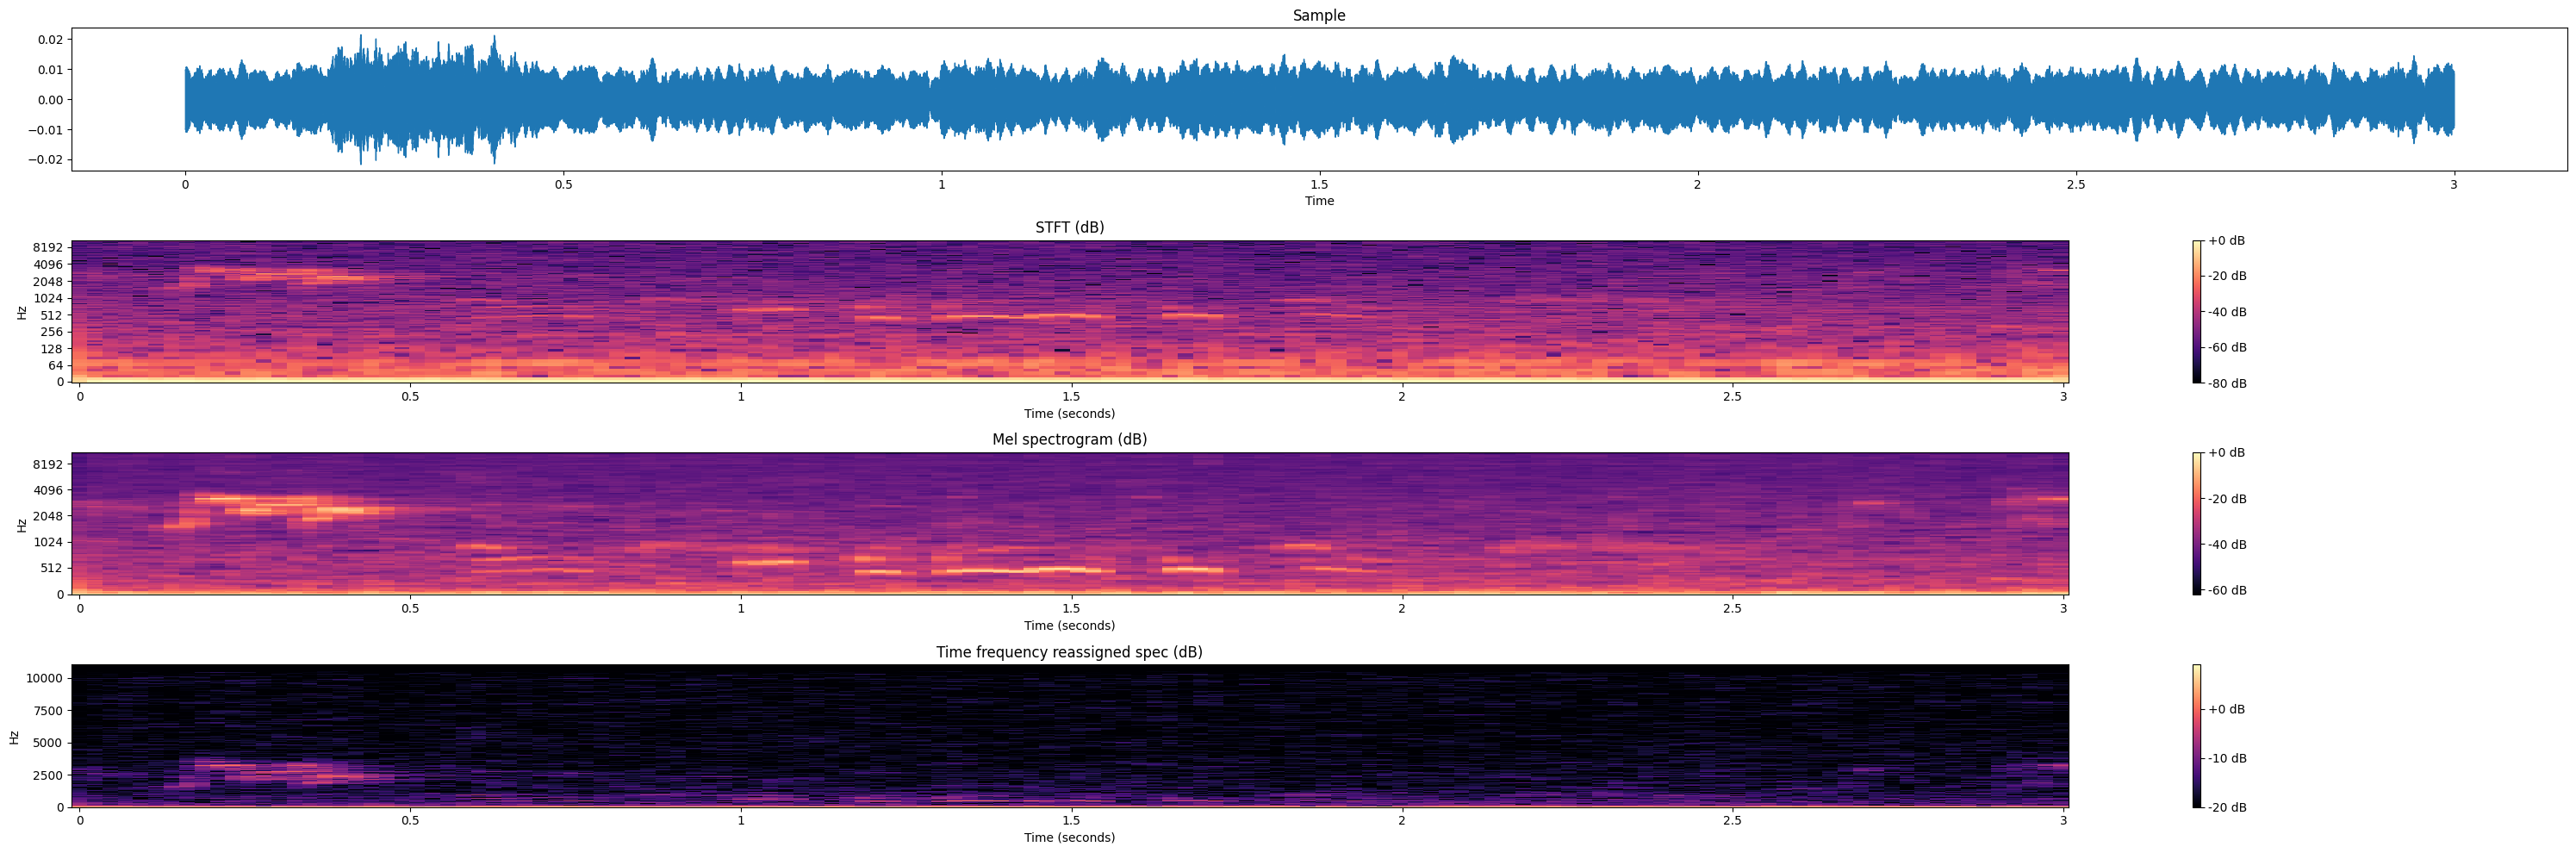

In [22]:
# species = "brubru1"
species = "lawgol"
r = df[df["Species eBird Code"] == species].sample(1).iloc[0]  # random example

example_file = recordings_path / r["Filename"]
center_time = (r["Start Time (s)"] + r["End Time (s)"]) / 2
dur = 3.0

y, sr = librosa.load(example_file, sr=None,
                     offset=max(0, center_time - dur/2),
                     duration=dur)

# Display spectrogram
show_specs(example_file, center_time, dur=dur)
display(Audio(y, rate=sr, autoplay=False))